## Modality-specific object selectivity
This code 

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  

from datetime import date
import time

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = Path('D:/Multi-modal project/')
fig_path = mother_path / 'analysis' / 'result' / 'figures'

### Parameter setting

In [4]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['tab:blue','tab:red','tab:gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
#save_path = mother_path /'analysis'/'result'/'4. Temporal patterns of object selectivity'/today

# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-06-26'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-06-26'
f = h5py.File(data_path/'2023-06-26_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-06-26_multiple_regression_result.hdf5','r')

In [6]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [7]:
df = h5_to_df(f2)
df = df[(df['Region']=='PER')&(df['Response cell']==0)]
df.reset_index(inplace=True,drop=True)

for key in df['key']:  
    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['Preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = np.argmax(f[f'{key}/anova_eta'])*10
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = f[key].attrs['Selectivity index']
    
    if f[key].attrs['Preferred object'] == 'Boy':
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        df.loc[df['key']==key,'coef_pref_int'] = f2[f'{key}/basic/beta_coef'][2]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][3]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][4]
        df.loc[df['key']==key,'coef_nonpref_int'] = f2[f'{key}/basic/beta_coef'][5]
    else:
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][3]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][4]
        df.loc[df['key']==key,'coef_pref_int'] = f2[f'{key}/basic/beta_coef'][5]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        df.loc[df['key']==key,'coef_nonpref_int'] = f2[f'{key}/basic/beta_coef'][2]
        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1        

### Classifying visual, auditory, and unbiased neurons

In [8]:
# classification based on permutation test (shuffling)
for i in range(len(df)):
    k = df.loc[i,'key']
    beta_diff = df.loc[i,'coef_pref_image']-df.loc[i,'coef_pref_sound']
    if df.loc[i,'pref_obj']=='Boy':
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])
    else:
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,3],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,4])
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df.loc[i,'Category'] = 'visual'
    elif beta_diff < auditory_crit:
        df.loc[i,'Category'] = 'auditory'
    else:
        df.loc[i,'Category'] = 'unbiased'

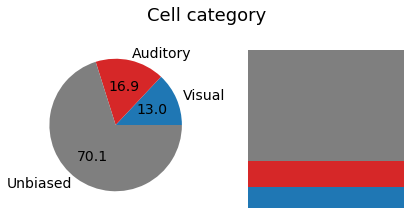

In [9]:
# proportion plot
x = [sum(df['Category']=='visual'), sum(df['Category']=='auditory'), sum(df['Category']=='unbiased')]

fig,ax = plt.subplots(1,2,figsize=(6,3))

fig.suptitle('Cell category', fontsize=18)
ax[0].pie(x,colors=color,labels=['Visual','Auditory','Unbiased'],autopct='%.1f',textprops={'fontsize':14});
ax[1].axis('off')
prev_data = 0
for i in range(3):
    ax[1].bar(1, height = x[i], bottom=prev_data, color=color[i])
    prev_data += x[i]

plt.tight_layout()
#plt.savefig(fig_path / 'cell_porportion_pie_bar.png', dpi=300,facecolor='white')

### Modality-specific response patterns

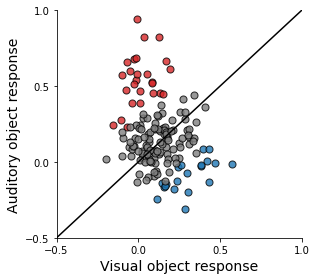

In [10]:
fig,ax = plt.subplots(figsize=(4.5,4))

gs = fig.add_gridspec(2,2, width_ratios=(4,1), height_ratios=(1,4))

#ax.scatter(df['coef_pref_image'],df['coef_pref_sound'], 
#           c = df['peak_selectivity_time_range'], cmap = 'viridis')
#norm = mpl.colors.Normalize(vmin=0,vmax=9)
#colormapping = mpl.cm.ScalarMappable(norm=norm,cmap=mpl.cm.viridis)
#fig.colorbar(colormapping, ax=plt.gca())

cat = ['visual','auditory','unbiased']
colors = ['tab:blue','tab:red','tab:gray']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'coef_pref_image']
    y = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax.scatter(x, y, facecolors=colors[c],edgecolors='k',alpha=0.8, s=50)

ax.plot(np.arange(-1,2.1,0.5),np.arange(-1,2.1,0.5),color='black')
ax.set_xticks(np.arange(-1,2.1,0.5));
ax.set_yticks(np.arange(-1,2.1,0.5));
ax.set_xlim([-0.5,1])
ax.set_ylim([-0.5,1])

#ax.set_xlabel('Coefficient for preferred image',fontsize=14);
#ax.set_ylabel('Coefficient for preferred sound',fontsize=14);

ax.set_xlabel('Visual object response',fontsize=14);
ax.set_ylabel('Auditory object response',fontsize=14);

plt.tight_layout()

#plt.savefig(fig_path / 'image_sound_scatter.png', dpi=300,facecolor='white')

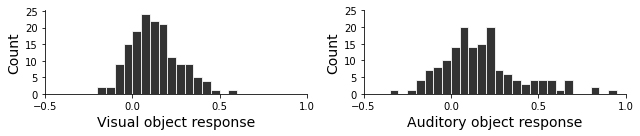

In [11]:
fig,ax = plt.subplots(1,2,figsize=(9,2))

x = ['coef_pref_image', 'coef_pref_sound']
xlabel = ['Visual object response', 'Auditory object response']

for i in range(2):
    ax[i].hist(df[x[i]], color='black', bins=np.arange(-0.5,1,0.05), alpha=0.8, ec='white');
    ax[i].set_xlabel(xlabel[i], fontsize=14);
    ax[i].set_xticks(np.arange(-0.5,1.5,0.5));
    ax[i].set_xlim([-0.5,1])
    ax[i].set_ylabel('Count', fontsize=14);
    ax[i].set_yticks(np.arange(0,30,5));

plt.tight_layout()
#plt.savefig(fig_path / 'image_sound_hist.png', dpi=300,facecolor='white')

In [12]:
pg.wilcoxon(df['coef_pref_image'],df['coef_pref_sound'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,5196.0,two-sided,0.164296,-0.129284,0.454461


### Temporal patterns of modality-specific response 

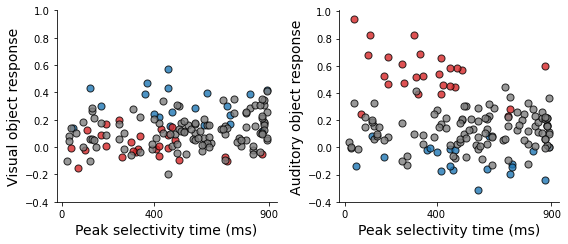

In [13]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'peak_selectivity_time']
    y = df.loc[df['Category']==cat[c],'coef_pref_image']        
    y2 = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax[0].scatter(x, y, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)

ylabel = ['Visual object response', 'Auditory object response']
for i in range(2):
    ax[i].set_xticks([0,400,900]);
    ax[i].set_xlabel('Peak selectivity time (ms)', fontsize=14);
    ax[i].set_yticks(np.arange(-0.4,1.2,0.2));
    ax[i].set_ylabel(ylabel[i], fontsize=14);

plt.tight_layout()
#plt.savefig(fig_path / 'coef_time_scatter.png', dpi=300,facecolor='white')

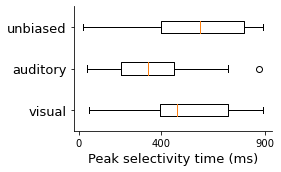

In [14]:
fig,ax = plt.subplots(figsize=(4,2.5))

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'peak_selectivity_time'] for c in x]
ax.boxplot(y, vert=False);
ax.set_yticklabels(x, fontsize=13);
ax.set_xticks([0, 400, 900]);
ax.set_xlabel('Peak selectivity time (ms)', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'category_time_boxplot.png', dpi=300,facecolor='white')

In [15]:
pg.kruskal(data=df, dv='peak_selectivity_time', between='Category')

,Source,ddof1,H,p-unc
Kruskal,Category,2,13.879906,0.000968


In [27]:
import scikit_posthocs as sp

data = [df.loc[df['Category']=='visual','peak_selectivity_time'],
        df.loc[df['Category']=='auditory','peak_selectivity_time'],
        df.loc[df['Category']=='unbiased', 'peak_selectivity_time']]
kruskal_posthoc = sp.posthoc_dunn(data, p_adjust = 'simes-hochberg')
kruskal_posthoc

,1,2,3
1,1.000000,0.072622,0.433484
2,0.072622,1.000000,0.000590
3,0.433484,0.000590,1.000000


In [18]:
print(pg.mwu(y[0],y[1])['p-val']*3)
print(pg.mwu(y[0],y[2])['p-val']*3)
print(pg.mwu(y[1],y[2])['p-val']*3)

MWU    0.057981
Name: p-val, dtype: float64
MWU    1.169493
Name: p-val, dtype: float64
MWU    0.000788
Name: p-val, dtype: float64


### Selectivity duration and modality-specific response

In [23]:
lr_v = sm.OLS(df['coef_pref_image'],sm.add_constant(df['selectivity_duration'])).fit()
lr_a = sm.OLS(df['coef_pref_sound'],sm.add_constant(df['selectivity_duration'])).fit()

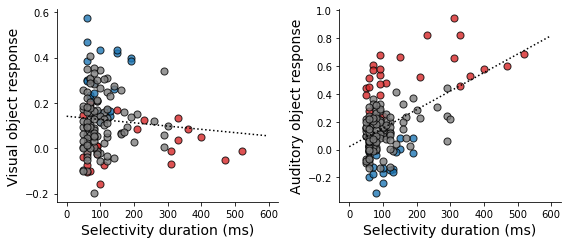

In [29]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'selectivity_duration']
    y = df.loc[df['Category']==cat[c],'coef_pref_image']
    y2 = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax[0].scatter(x, y, facecolors=colors[c], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolors=colors[c], edgecolors='k', alpha=0.8, s=50)
    
ylabel = ['Visual object response', 'Auditory object response']
for i in range(2):
    ax[i].set_xticks(np.arange(0,700,100));
    ax[i].set_xlabel('Selectivity duration (ms)', fontsize=14);
    ax[i].set_yticks(np.arange(-0.4,1.2,0.2));
    ax[i].set_ylabel(ylabel[i], fontsize=14);
    
x = np.arange(0,600,1)
ax[0].plot(x, x*lr_v.params[1]+lr_v.params[0], linestyle=':', color='black')
ax[1].plot(x, x*lr_a.params[1]+lr_a.params[0], linestyle=':', color='black')

plt.tight_layout()
plt.savefig(fig_path / 'duration_coef_scatter.png', dpi=300,facecolor='white')

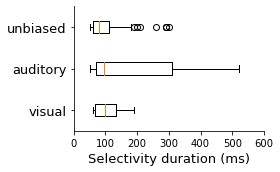

In [215]:
fig,ax = plt.subplots(figsize=(4,2.5))

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'selectivity_duration'] for c in x]
ax.boxplot(y, vert=False);
ax.set_yticklabels(x, fontsize=13);
ax.set_xticks(np.arange(0,700,100));
ax.set_xlabel('Selectivity duration (ms)', fontsize=13)

plt.tight_layout()
plt.savefig(fig_path / 'category_duration_boxplot.png', dpi=300,facecolor='white')

In [206]:
pg.kruskal(data=df, dv='selectivity_duration', between='Category')

,Source,ddof1,H,p-unc
Kruskal,Category,2,6.860279,0.032382


In [208]:
print(pg.mwu(y[0],y[1])['p-val']*3)
print(pg.mwu(y[0],y[2])['p-val']*3)
print(pg.mwu(y[1],y[2])['p-val']*3)

MWU    0.916549
Name: p-val, dtype: float64
MWU    0.573886
Name: p-val, dtype: float64
MWU    0.045974
Name: p-val, dtype: float64


### PCA (not used)

In [158]:
np.cumsum(explained_variance)

array([0.5173942 , 0.72787739, 0.89278611, 0.94923584, 0.98701374,
       1.        ])

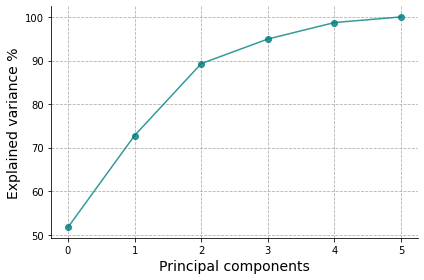

In [162]:
pca = PCA()
pca.fit_transform(df.iloc[:,10:-1])

explained_variance=pca.explained_variance_ratio_

plt.figure(figsize=(6, 4))

plt.plot(range(6), np.cumsum(explained_variance)*100,marker='o',color='teal',alpha=0.8)
plt.ylabel('Explained variance %',fontsize=14)
plt.xlabel('Principal components',fontsize=14)
plt.grid(linestyle='--')
plt.tight_layout()

Text(0, 0.5, 'PC2')

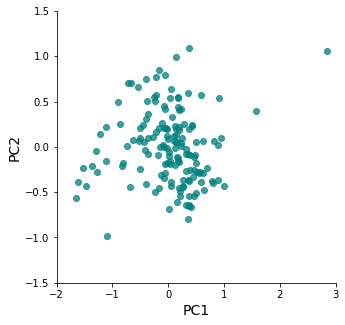

In [163]:
# dimensionality reduction to 2 PCs
pca = PCA(n_components=2).fit_transform(df.iloc[:,10:-1])

fig,ax = plt.subplots(figsize=(5,5))

ax.plot(pca[:,0],pca[:,1],marker='o',color='teal',alpha=0.75,linewidth=0)
ax.set_xlim([-2,3]);
ax.set_xlabel('PC1',fontsize=14)
ax.set_ylim([-1.5,1.5]);
ax.set_ylabel('PC2',fontsize=14)